<a href="https://colab.research.google.com/github/harshk-0711/Fashion/blob/main/assignment2_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd

In [ ]:
# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameters
batch_size = 256
latent_dim = 20
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Step 2: Define the VAE model
class VAE(nn.Module):
    # Define your VAE model here

    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU()
        )
        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)


        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Add Sigmoid activation to ensure output values are between 0 and 1
        )


    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = self.mu(h), self.log_var(h)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

In [ ]:
# Step 1: Load and preprocess Fashion MNIST dataset
class FashionMNISTDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape((28, 28))
        label = self.data.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = FashionMNISTDataset('/content/drive/MyDrive/dataset/fashion-mnist_train.csv', transform=transform)
test_dataset = FashionMNISTDataset('/content/drive/MyDrive/dataset/fashion-mnist_test.csv', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
# Instantiate the model
model = VAE(latent_dim).to(device)

In [ ]:


# Define the loss function
def loss_function(x_recon, x, mu, log_var):
    reconstruction_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



In [ ]:
# Training loop
for epoch in range(epochs):
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, log_var = model(x)
        loss = loss_function(x_recon, x, mu, log_var)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item() / batch_size:.4f}')
# Save the trained model
torch.save(model.state_dict(), 'vae.pth')

Epoch: 1/10, Batch: 1/235, Loss: 545.3712
Epoch: 1/10, Batch: 101/235, Loss: 288.3713
Epoch: 1/10, Batch: 201/235, Loss: 264.1024
Epoch: 2/10, Batch: 1/235, Loss: 260.5363
Epoch: 2/10, Batch: 101/235, Loss: 254.4851
Epoch: 2/10, Batch: 201/235, Loss: 256.1484
Epoch: 3/10, Batch: 1/235, Loss: 253.9570
Epoch: 3/10, Batch: 101/235, Loss: 246.9822
Epoch: 3/10, Batch: 201/235, Loss: 251.7657
Epoch: 4/10, Batch: 1/235, Loss: 252.5118
Epoch: 4/10, Batch: 101/235, Loss: 248.1817
Epoch: 4/10, Batch: 201/235, Loss: 251.0746
Epoch: 5/10, Batch: 1/235, Loss: 241.1496
Epoch: 5/10, Batch: 101/235, Loss: 252.5798
Epoch: 5/10, Batch: 201/235, Loss: 247.0293
Epoch: 6/10, Batch: 1/235, Loss: 241.7275
Epoch: 6/10, Batch: 101/235, Loss: 243.2250
Epoch: 6/10, Batch: 201/235, Loss: 246.7683
Epoch: 7/10, Batch: 1/235, Loss: 236.1183
Epoch: 7/10, Batch: 101/235, Loss: 234.1674
Epoch: 7/10, Batch: 201/235, Loss: 234.3746
Epoch: 8/10, Batch: 1/235, Loss: 250.7265
Epoch: 8/10, Batch: 101/235, Loss: 241.1396
Epoc

In [ ]:
# Load the saved model
model = VAE(latent_dim)
model.load_state_dict(torch.load('vae.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=256, bias=True)
    (6): ReLU()
  )
  (mu): Linear(in_features=256, out_features=20, bias=True)
  (log_var): Linear(in_features=256, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3136, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): Sigmoid()
  )
)

In [ ]:
# Generate random latent vectors
num_samples = 10  # Number of samples to generate
latent_vectors = torch.randn(num_samples, latent_dim).to(device)

In [ ]:
# Generate new samples
with torch.no_grad():
    generated_samples = model.decoder(latent_vectors).cpu().numpy()

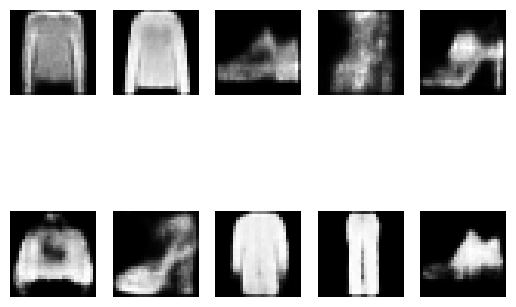

In [ ]:
import matplotlib.pyplot as plt

# Visualize the generated samples
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_samples[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

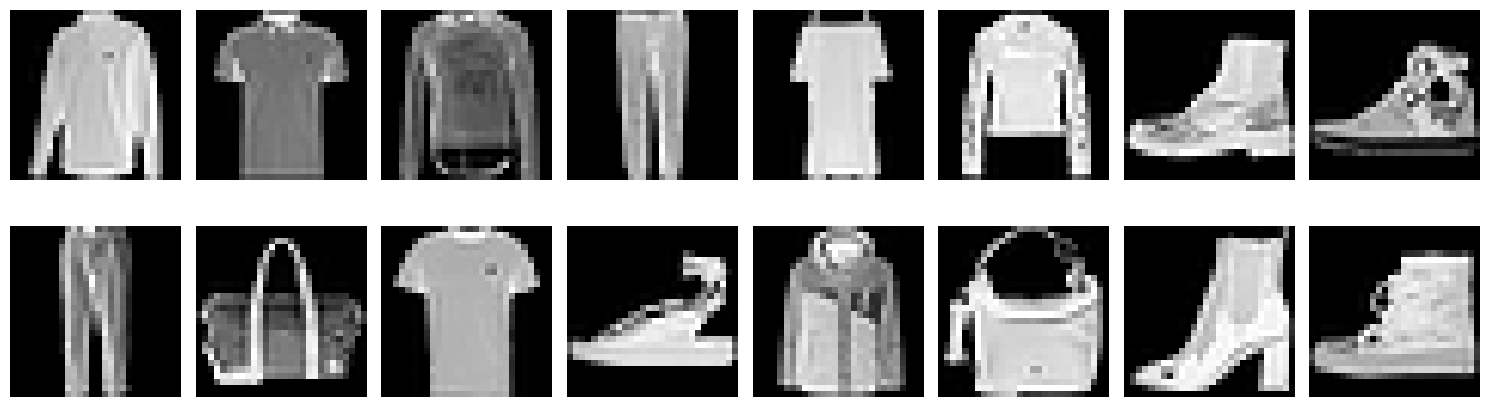

In [ ]:

# Visualize training images
train_images = next(iter(train_loader))[0][:16]  # Get the first 16 images from the next batch

# Plot training images
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(15, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()



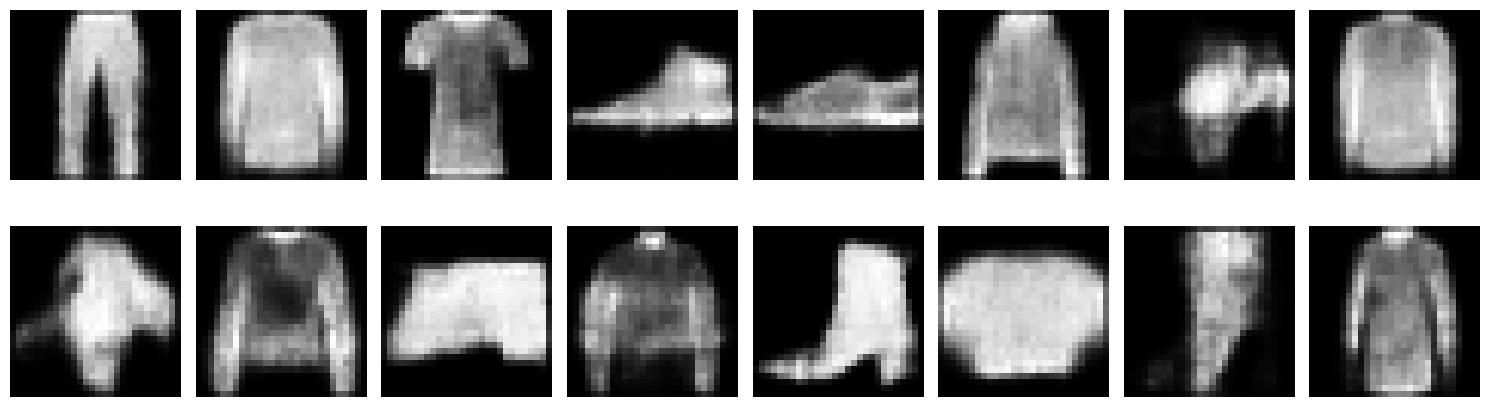

Synthetic image 0 is not present in the original dataset.
Synthetic image 1 is not present in the original dataset.
Synthetic image 2 is not present in the original dataset.
Synthetic image 3 is not present in the original dataset.
Synthetic image 4 is not present in the original dataset.
Synthetic image 5 is not present in the original dataset.
Synthetic image 6 is not present in the original dataset.
Synthetic image 7 is not present in the original dataset.
Synthetic image 8 is not present in the original dataset.
Synthetic image 9 is not present in the original dataset.
Synthetic image 10 is not present in the original dataset.
Synthetic image 11 is not present in the original dataset.
Synthetic image 12 is not present in the original dataset.
Synthetic image 13 is not present in the original dataset.
Synthetic image 14 is not present in the original dataset.
Synthetic image 15 is not present in the original dataset.


In [ ]:
# Generate synthetic images
with torch.no_grad():
    latent_vectors = torch.randn(16, latent_dim).to(device)
    synthetic_images = model.decoder(latent_vectors).cpu()

# Plot synthetic images
fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(15, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(synthetic_images[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Check if synthetic images are present in the original dataset
# Convert DataFrame to tensor and preprocess
# Convert DataFrame to tensor and preprocess
dataset_images = torch.tensor(train_dataset.data.values[:, 1:], dtype=torch.float32)  # Exclude the label column
dataset_images = dataset_images.view(-1, 1, 28, 28) / 255.0


synthetic_images = synthetic_images.view(-1, 1, 28, 28)

for i, synthetic_image in enumerate(synthetic_images):
    diff = (dataset_images - synthetic_image).abs().sum(dim=(1, 2, 3))
    if diff.min() == 0:
        print(f"Synthetic image {i} is present in the original dataset.")
    else:
        print(f"Synthetic image {i} is not present in the original dataset.")
